## Import libraries and load raw the Parkinson’s Drawings Dataset

In [1]:
import os
from collections import defaultdict
from itertools import product
import random
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import re
from collections import defaultdict
import itertools

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import ColorJitter
import torch.optim as optim


In [2]:
base_path = '/kaggle/input/parkinsons-drawings'

spiral_training_healthy_path = os.path.join(base_path, 'spiral/training/healthy')
spiral_training_parkinson_path = os.path.join(base_path, 'spiral/training/parkinson')
wave_training_healthy_path = os.path.join(base_path, 'wave/training/healthy')
wave_training_parkinson_path = os.path.join(base_path, 'wave/training/parkinson')

spiral_test_healthy_path = os.path.join(base_path, 'spiral/testing/healthy')
spiral_test_parkinson_path = os.path.join(base_path, 'spiral/testing/parkinson')
wave_test_healthy_path = os.path.join(base_path, 'wave/testing/healthy')
wave_test_parkinson_path = os.path.join(base_path, 'wave/testing/parkinson')

## Data pre-processing
### Image pairs formation and splitting in training, validation, test datasets

In [3]:
def get_pairs(spiral_training_path, wave_training_path, spiral_test_path, wave_test_path):
    # Load filenames and prefix with full paths
    spiral_training_file_paths = [os.path.join(spiral_training_path, f) for f in os.listdir(spiral_training_path)]
    spiral_test_file_paths = [os.path.join(spiral_test_path, f) for f in os.listdir(spiral_test_path)]
    wave_training_file_paths = [os.path.join(wave_training_path, f) for f in os.listdir(wave_training_path)]
    wave_test_file_paths = [os.path.join(wave_test_path, f) for f in os.listdir(wave_test_path)]

    # Combine original training and test files
    spiral_file_paths = spiral_training_file_paths + spiral_test_file_paths
    wave_file_paths = wave_training_file_paths + wave_test_file_paths

    # Group by subject ID
    spiral_by_id = defaultdict(list)
    wave_by_id = defaultdict(list)

    for path in spiral_file_paths:
        filename = os.path.basename(path)
        pid = re.findall(r'\d+', filename)[0]
        spiral_by_id[pid].append(path)

    for path in wave_file_paths:
        filename = os.path.basename(path)
        pid = re.findall(r'\d+', filename)[0]
        wave_by_id[pid].append(path)

    # Find common IDs and create all (spiral, wave) pairs
    common_ids = set(spiral_by_id.keys()) & set(wave_by_id.keys())
    all_matching_pairs = []
    for pid in common_ids:
        for pair in itertools.product(spiral_by_id[pid], wave_by_id[pid]):
            all_matching_pairs.append(pair)

    # Sort by subject ID extracted from filename
    sorted_pairs = sorted(all_matching_pairs, key=lambda x: int(re.findall(r'\d+', os.path.basename(x[0]))[0]))
    return sorted_pairs

# Split person_id keys into train/val/test sets
def split_healthy_pairs_by_id(pairs):
    train_pairs = []
    val_pairs = []
    test_pairs = []

    for spiral_img, wave_img in pairs:
        match = re.search(r'V(\d{2})', spiral_img)
        if match:
            indiv_id = int(match.group(1))
            if indiv_id == 55:
                train_pairs.append((spiral_img, wave_img))
            elif 1 <= indiv_id <= 6:
                val_pairs.append((spiral_img, wave_img))
            elif 7 <= indiv_id <= 13:
                test_pairs.append((spiral_img, wave_img))

    return train_pairs, val_pairs, test_pairs

def split_parkinson_pairs_by_id(pairs):
    train_pairs = []
    val_pairs = []
    test_pairs = []

    for spiral_img, wave_img in pairs:
        match = re.search(r'V(\d{2})', spiral_img)
        if match:
            indiv_id = int(match.group(1))
            if indiv_id <= 8:
                train_pairs.append((spiral_img, wave_img))
            elif 9 <= indiv_id <= 12:
                val_pairs.append((spiral_img, wave_img))
            elif 13 <= indiv_id:
                test_pairs.append((spiral_img, wave_img))

    return train_pairs, val_pairs, test_pairs

In [4]:
healthy_pairs = get_pairs(spiral_training_healthy_path, wave_training_healthy_path, spiral_test_healthy_path, wave_test_healthy_path)
print(f'Number of healthy pairs: {len(healthy_pairs)}')

parkinson_pairs = get_pairs(spiral_training_parkinson_path, wave_training_parkinson_path, spiral_test_parkinson_path, wave_test_parkinson_path)
print(f'Number of healthy pairs: {len(parkinson_pairs)}')

healthy_train, healthy_val, healthy_test = split_healthy_pairs_by_id(healthy_pairs)

print('training, val, test healthy split')
print(len(healthy_train))
print(len(healthy_val))
print(len(healthy_test))

patient_train, patient_val, patient_test = split_parkinson_pairs_by_id(parkinson_pairs)

print('training, val, test parkinson split')
print(len(patient_train))
print(len(patient_val))
print(len(patient_test))

Number of healthy pairs: 333
Number of healthy pairs: 207
training, val, test healthy split
225
54
54
training, val, test parkinson split
144
36
27


### Dataset building for original image pairs and for data augmentation (horizontal flipping, vertical flipping, contrast and illumination)

In [5]:
class Dataset_no_data_aug(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.pairs = pairs
        self.label = label
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        spiral_path, meander_path = self.pairs[idx]
        
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")

        # Resize to 128x128 dimensions
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Save in tensor
        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        # Normalization
        mean = [0.485, 0.456, 0.406]  
        std = [0.229, 0.224, 0.225]  
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y


class Dataset_hflip(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.label = label
        self.img_size = img_size
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_flip = self.expanded_pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")

        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply horizontal flipping
        if apply_flip:
            spiral_img = TF.hflip(spiral_img)
            meander_img = TF.hflip(meander_img)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y

class Dataset_vflip(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.label = label
        self.img_size = img_size
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_flip = self.expanded_pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")
        
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply vertical flipping
        if apply_flip:
            spiral_img = TF.vflip(spiral_img)
            meander_img = TF.vflip(meander_img)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y



class Dataset_contrast(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128), contrast_factor_range=(0.5, 1.5)):
        self.label = label
        self.img_size = img_size
        self.contrast_factor_range = contrast_factor_range  # Range for contrast adjustment
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_contrast = self.expanded_pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")
        
    
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply contrast augmentation
        if apply_contrast:
            contrast_factor = random.uniform(*self.contrast_factor_range)
            spiral_img = TF.adjust_contrast(spiral_img, contrast_factor)
            meander_img = TF.adjust_contrast(meander_img, contrast_factor)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y

class Dataset_illumination(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.label = label
        self.img_size = img_size
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_illum = self.expanded_pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")
        
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply illumination augmentation
        if apply_illum:
            factor = random.uniform(0.6, 1.4)
            spiral_img = TF.adjust_brightness(spiral_img, factor)
            meander_img = TF.adjust_brightness(meander_img, factor)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y


### Combine healthy and PD labeled image pair datasets

In [6]:
def create_dataset_no_data_aug(pairs_healthy, pairs_patient, img_size=(128, 128)):
    dataset = (
        Dataset_no_data_aug(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_no_data_aug(pairs_patient, label=1,
                          img_size=img_size)
    )
    return dataset


def create_dataset_hflip(pairs_healthy, pairs_patient, img_size=(128, 128)):
    dataset = (
        Dataset_hflip(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_hflip(pairs_patient, label=1,
                          img_size=img_size)
    )
    return dataset

def create_dataset_vflip(pairs_healthy, pairs_patient, img_size=(128, 128)):
    dataset = (
        Dataset_vflip(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_vflip(pairs_patient, label=1,
                          img_size=img_size)
    )
    return dataset

def create_dataset_contrast(pairs_healthy, pairs_patient, img_size=(128, 128)):
    dataset = (
        Dataset_contrast(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_contrast(pairs_patient, label=1,
                          img_size=img_size)
    )
    return dataset

def create_dataset_illumination(pairs_healthy, pairs_patient, img_size=(128, 128)):
    dataset = (
        Dataset_illumination(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_illumination(pairs_patient, label=1,
                          img_size=img_size)
    )
    return dataset

train_dataset = create_dataset_no_data_aug(healthy_train, patient_train, img_size=(128,128))
val_dataset   = create_dataset_no_data_aug(healthy_val, patient_val, img_size=(128,128))
test_dataset  = create_dataset_no_data_aug(healthy_test, patient_test, img_size=(128,128))

train_dataset_hflip = create_dataset_hflip(healthy_train, patient_train, img_size=(128,128))
train_dataset_vflip = create_dataset_vflip(healthy_train, patient_train, img_size=(128,128))
train_dataset_contrast = create_dataset_contrast(healthy_train, patient_train, img_size=(128,128))
train_dataset_illumination = create_dataset_illumination(healthy_train, patient_train, img_size=(128,128))

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(len(train_dataset_hflip))
print(len(train_dataset_vflip))
print(len(train_dataset_contrast))
print(len(train_dataset_illumination))


369
90
81
738
738
738
738


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader_hflip = DataLoader(train_dataset_hflip, batch_size=32, shuffle=True)
train_loader_vflip = DataLoader(train_dataset_vflip, batch_size=32, shuffle=True)
train_loader_contrast = DataLoader(train_dataset_contrast, batch_size=32, shuffle=True)
train_loader_illumination = DataLoader(train_dataset_illumination, batch_size=32, shuffle=True)

### Adapt different dataset classes to combine them and have the original pair only once

In [11]:
class Dataset_no_data_aug2(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.pairs = pairs
        self.label = label
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        spiral_path, meander_path = self.pairs[idx]
        
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")


class Dataset_hflip2(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.label = label
        self.img_size = img_size
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        spiral_path, meander_path = self.pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")

        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        spiral_img = TF.hflip(spiral_img)
        meander_img = TF.hflip(meander_img)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y

class Dataset_vflip2(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.label = label
        self.img_size = img_size
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        spiral_path, meander_path = self.pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")
        
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        spiral_img = TF.vflip(spiral_img)
        meander_img = TF.vflip(meander_img)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y

class Dataset_contrast2(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128), contrast_factor_range=(0.5, 1.5)):
        self.label = label
        self.img_size = img_size
        self.contrast_factor_range = contrast_factor_range  
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        spiral_path, meander_path = self.pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")
        
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        contrast_factor = random.uniform(*self.contrast_factor_range)
        spiral_img = TF.adjust_contrast(spiral_img, contrast_factor)
        meander_img = TF.adjust_contrast(meander_img, contrast_factor)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y

class Dataset_illumination2(Dataset):
    def __init__(self, pairs, label, img_size=(128, 128)):
        self.label = label
        self.img_size = img_size
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        spiral_path, meander_path = self.pairs[idx]
        spiral_img = Image.open(spiral_path).convert("RGB")
        meander_img = Image.open(meander_path).convert("RGB")
        
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        factor = random.uniform(0.6, 1.4)
        spiral_img = TF.adjust_brightness(spiral_img, factor)
        meander_img = TF.adjust_brightness(meander_img, factor)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y


## Definition of the Intermediate Fusion multimodal model architecture 

In [8]:
class IntermediateFusionResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(IntermediateFusionResNet, self).__init__()

        # Load pretrained ResNet18s
        base_spiral = models.resnet18(pretrained=True)
        base_meander = models.resnet18(pretrained=True)
        base_shared = models.resnet18(pretrained=True)

        # Separate early layers up to layer3
        self.spiral_early = nn.Sequential(
            base_spiral.conv1,
            base_spiral.bn1,
            base_spiral.relu,
            base_spiral.maxpool,
            base_spiral.layer1,
            base_spiral.layer2,
            base_spiral.layer3
        )

        self.meander_early = nn.Sequential(
            base_meander.conv1,
            base_meander.bn1,
            base_meander.relu,
            base_meander.maxpool,
            base_meander.layer1,
            base_meander.layer2,
            base_meander.layer3
        )

        self.reduce_spiral = nn.Linear(256, 128)
        self.reduce_meander = nn.Linear(256, 128)

        # Late resnet18 after fusion
        self.shared_late = nn.Sequential(
            base_shared.layer4,
            base_shared.avgpool
        )

        # Classifier 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, spiral_img, meander_img):
        # Early feature extraction
        spiral_feat = self.spiral_early(spiral_img)     
        meander_feat = self.meander_early(meander_img) 
    
        # Global Average Pooling
        spiral_feat = torch.nn.functional.adaptive_avg_pool2d(spiral_feat, (1, 1)).squeeze(-1).squeeze(-1) 
        meander_feat = torch.nn.functional.adaptive_avg_pool2d(meander_feat, (1, 1)).squeeze(-1).squeeze(-1)
    
        # Dimensionality reduction
        spiral_feat = self.reduce_spiral(spiral_feat)  
        meander_feat = self.reduce_meander(meander_feat)
    
        # Intermediate fusion 
        fused_feat = torch.cat((spiral_feat, meander_feat), dim=1)  
        fused_feat = fused_feat.unsqueeze(-1).unsqueeze(-1)  
    
        # Late ResNet18 layers
        fused_feat = self.shared_late(fused_feat) 
    
        # Classifier
        out = self.classifier(fused_feat) 
        return out


In [9]:
def evaluate_model(model, val_loader, device):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():  
        for spiral_img, meander_img, labels in val_loader:
            spiral_img, meander_img, labels = spiral_img.to(device), meander_img.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(spiral_img, meander_img)

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)

            # Update correct and total counters
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = correct / total
    return accuracy

def train_model2(model, train_loader, val_loader, epochs=10, device=None):
    model.train()

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        train_loss, correct, total = 0.0, 0, 0

        for spiral_img, meander_img, labels in train_loader:
            spiral_img, meander_img, labels = spiral_img.to(device), meander_img.to(device), labels.to(device)

            # Zero the gradients before running the backward pass
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(spiral_img, meander_img)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagate and update weights
            loss.backward()
            optimizer.step()

            # Accumulate the loss and calculate accuracy
            train_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        val_accuracy = evaluate_model(model, val_loader, device)

        train_losses.append(train_loss/total)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/total:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_accuracies

In [10]:
def test_model(model, test_loader, device):
    model.eval()  
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  
        for spiral_img, meander_img, labels in test_loader:
            spiral_img, meander_img, labels = spiral_img.to(device), meander_img.to(device), labels.to(device)

            # Forward pass
            outputs = model(spiral_img, meander_img)

            # Get predicted class labels
            _, predicted = torch.max(outputs, 1)

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute final accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, all_predictions, all_labels


## Create a dataset by combining the 4 types of data augmentation

In [12]:
def create_dataset_all_aug(pairs_healthy, pairs_patient, img_size=(128, 128)):
    dataset = (
        Dataset_no_data_aug2(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_no_data_aug2(pairs_patient, label=1,
                          img_size=img_size) + 
        Dataset_hflip2(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_hflip2(pairs_patient, label=1,
                          img_size=img_size) +
        Dataset_vflip2(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_vflip2(pairs_patient, label=1,
                          img_size=img_size) +
        Dataset_contrast2(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_contrast2(pairs_patient, label=1,
                          img_size=img_size) +
        Dataset_illumination2(pairs_healthy, label=0,
                          img_size=img_size) +
        Dataset_illumination2(pairs_patient, label=1,
                          img_size=img_size)
    )
    return dataset


train_dataset_all = create_dataset_all_aug(healthy_train, patient_train, img_size=(128,128))

print(len(train_dataset_all))


1845


## Adapt the intermediate fusion model for transfer learning

In [13]:
class Intermediate_transfer(nn.Module):
    def __init__(self, num_classes=2, freeze_early=True):
        super(Intermediate_transfer, self).__init__()

        base_spiral = models.resnet18(pretrained=True)
        base_meander = models.resnet18(pretrained=True)
        base_shared = models.resnet18(pretrained=True)

        self.spiral_early = nn.Sequential(
            base_spiral.conv1,
            base_spiral.bn1,
            base_spiral.relu,
            base_spiral.maxpool,
            base_spiral.layer1,
            base_spiral.layer2,
            base_spiral.layer3
        )

        self.meander_early = nn.Sequential(
            base_meander.conv1,
            base_meander.bn1,
            base_meander.relu,
            base_meander.maxpool,
            base_meander.layer1,
            base_meander.layer2,
            base_meander.layer3
        )

        self.reduce_spiral = nn.Linear(256, 128)
        self.reduce_meander = nn.Linear(256, 128)

        self.shared_late = nn.Sequential(
            base_shared.layer4,
            base_shared.avgpool
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        # Choose which layers to freeze
        if freeze_early:
            for param in self.spiral_early.parameters():
                param.requires_grad = False
            for param in self.meander_early.parameters():
                param.requires_grad = False

    def forward(self, spiral_img, meander_img):
        spiral_feat = self.spiral_early(spiral_img)
        meander_feat = self.meander_early(meander_img)

        spiral_feat = torch.nn.functional.adaptive_avg_pool2d(spiral_feat, (1, 1)).squeeze(-1).squeeze(-1)
        meander_feat = torch.nn.functional.adaptive_avg_pool2d(meander_feat, (1, 1)).squeeze(-1).squeeze(-1)

        spiral_feat = self.reduce_spiral(spiral_feat)
        meander_feat = self.reduce_meander(meander_feat)

        fused_feat = torch.cat((spiral_feat, meander_feat), dim=1)
        fused_feat = fused_feat.unsqueeze(-1).unsqueeze(-1)

        fused_feat = self.shared_late(fused_feat)

        out = self.classifier(fused_feat)
        return out


## Training without using the hyperparamters model 1 and 2 in the NewHandPD investigation but not the saved weights

In [19]:
train_loader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Intermediate_transfer(num_classes=2, freeze_early=True)
model.load_state_dict(torch.load("/kaggle/input/best-models/model1.pt"))
model.to(device)

train_loader = train_loader_contrast

lr = 0.0005
wd = 0.0

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(trainable_params, lr=lr, weight_decay=wd, momentum=0.9)

criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_accuracies = train_model2(model, train_loader, val_loader, epochs=10, device=device)
acc, _, _ = test_model(model, test_loader, device)

/tmp/ipykernel_31/3485298994.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/best-models/model1.pt"))


Epoch [1/10] - Loss: 0.4831, Train Acc: 0.7764, Val Acc: 0.5333
Epoch [2/10] - Loss: 0.0695, Train Acc: 0.9797, Val Acc: 0.4000
Epoch [3/10] - Loss: 0.8411, Train Acc: 0.6504, Val Acc: 0.4000
Epoch [4/10] - Loss: 0.4124, Train Acc: 0.8144, Val Acc: 0.4333
Epoch [5/10] - Loss: 0.1024, Train Acc: 0.9580, Val Acc: 0.5111
Epoch [6/10] - Loss: 0.0388, Train Acc: 0.9851, Val Acc: 0.8000
Epoch [7/10] - Loss: 0.0210, Train Acc: 0.9919, Val Acc: 0.4000
Epoch [8/10] - Loss: 0.0567, Train Acc: 0.9770, Val Acc: 0.7222
Epoch [9/10] - Loss: 0.0032, Train Acc: 1.0000, Val Acc: 0.6444
Epoch [10/10] - Loss: 0.0008, Train Acc: 1.0000, Val Acc: 0.6444
Test Accuracy: 0.9136


In [20]:
train_loader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_class = IntermediateFusionResNet
train_loader = train_loader_contrast

lr = 0.0005
wd = 0.0

model = model_class(num_classes=2).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_accuracies = train_model2(model, train_loader, val_loader, epochs=10, device=device)
acc, _, _ = test_model(model, test_loader, device)


Epoch [1/10] - Loss: 0.5301, Train Acc: 0.7480, Val Acc: 0.6222
Epoch [2/10] - Loss: 0.3621, Train Acc: 0.8794, Val Acc: 0.7222
Epoch [3/10] - Loss: 0.1151, Train Acc: 0.9621, Val Acc: 0.6778
Epoch [4/10] - Loss: 0.0116, Train Acc: 0.9973, Val Acc: 0.5667
Epoch [5/10] - Loss: 0.0022, Train Acc: 1.0000, Val Acc: 0.5000
Epoch [6/10] - Loss: 0.0014, Train Acc: 1.0000, Val Acc: 0.5111
Epoch [7/10] - Loss: 0.0013, Train Acc: 1.0000, Val Acc: 0.5444
Epoch [8/10] - Loss: 0.0006, Train Acc: 1.0000, Val Acc: 0.4778
Epoch [9/10] - Loss: 0.0006, Train Acc: 1.0000, Val Acc: 0.5333
Epoch [10/10] - Loss: 0.0004, Train Acc: 1.0000, Val Acc: 0.4778
Test Accuracy: 0.7284


## Training while using the weights of the already trained models 1 and 2 from NewHandPD investigation

In [22]:
#Load the saved model 1
model = Intermediate_transfer(num_classes=2, freeze_early=True)
model.load_state_dict(torch.load("/kaggle/input/best-models/model1.pt"))
model.to(device)

train_loader = train_loader_contrast

lr = 0.0005
wd = 0.0

# Define the trainable parameters
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(trainable_params, lr=lr, weight_decay=wd, momentum=0.9)

criterion = nn.CrossEntropyLoss()

train_losses1, train_accuracies1, val_accuracies1 = train_model2(model, train_loader, val_loader, epochs=20, device=device)
acc1, _, _ = test_model(model, test_loader, device)

/tmp/ipykernel_31/2014401244.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/best-models/model1.pt"))


Epoch [1/20] - Loss: 0.4854, Train Acc: 0.7954, Val Acc: 0.5222
Epoch [2/20] - Loss: 0.0720, Train Acc: 0.9770, Val Acc: 0.6778
Epoch [3/20] - Loss: 0.0142, Train Acc: 0.9959, Val Acc: 0.6556
Epoch [4/20] - Loss: 0.0008, Train Acc: 1.0000, Val Acc: 0.6333
Epoch [5/20] - Loss: 0.0473, Train Acc: 0.9837, Val Acc: 0.5556
Epoch [6/20] - Loss: 0.0080, Train Acc: 0.9946, Val Acc: 0.7333
Epoch [7/20] - Loss: 0.0632, Train Acc: 0.9729, Val Acc: 0.6444
Epoch [8/20] - Loss: 0.0075, Train Acc: 0.9973, Val Acc: 0.7333
Epoch [9/20] - Loss: 0.0012, Train Acc: 1.0000, Val Acc: 0.5556
Epoch [10/20] - Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.7444
Epoch [11/20] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.7444
Epoch [12/20] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.7556
Epoch [13/20] - Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.7222
Epoch [14/20] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.6778
Epoch [15/20] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.6556
Epoch [16/20] - Loss: 0.0000, Trai

In [23]:
#Load the saved model 2
model = Intermediate_transfer(num_classes=2, freeze_early=True)
model.load_state_dict(torch.load("/kaggle/input/best-models/model2.pt"))
model.to(device)

train_loader = train_loader_contrast

lr = 0.0001
wd = 0.0001

# Define the trainable parameters
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=wd)

criterion = nn.CrossEntropyLoss()

train_losses2, train_accuracies2, val_accuracies2 = train_model2(model, train_loader, val_loader, epochs=20, device=device)
acc2, _, _ = test_model(model, test_loader, device)

/tmp/ipykernel_31/3621711145.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/best-models/model2.pt"))


Epoch [1/20] - Loss: 0.3611, Train Acc: 0.8496, Val Acc: 0.5556
Epoch [2/20] - Loss: 0.0715, Train Acc: 0.9756, Val Acc: 0.5667
Epoch [3/20] - Loss: 0.0125, Train Acc: 0.9946, Val Acc: 0.7667
Epoch [4/20] - Loss: 0.0078, Train Acc: 0.9973, Val Acc: 0.6778
Epoch [5/20] - Loss: 0.0034, Train Acc: 0.9986, Val Acc: 0.5778
Epoch [6/20] - Loss: 0.0024, Train Acc: 1.0000, Val Acc: 0.7222
Epoch [7/20] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.8222
Epoch [8/20] - Loss: 0.0002, Train Acc: 1.0000, Val Acc: 0.6111
Epoch [9/20] - Loss: 0.0012, Train Acc: 1.0000, Val Acc: 0.7333
Epoch [10/20] - Loss: 0.0773, Train Acc: 0.9702, Val Acc: 0.7556
Epoch [11/20] - Loss: 0.0264, Train Acc: 0.9892, Val Acc: 0.8000
Epoch [12/20] - Loss: 0.0047, Train Acc: 0.9986, Val Acc: 0.7444
Epoch [13/20] - Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.7778
Epoch [14/20] - Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.7889
Epoch [15/20] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.7889
Epoch [16/20] - Loss: 0.0000, Trai

### Display results

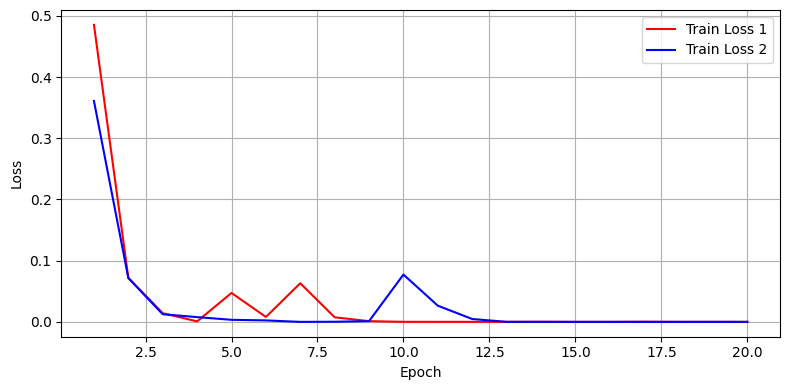

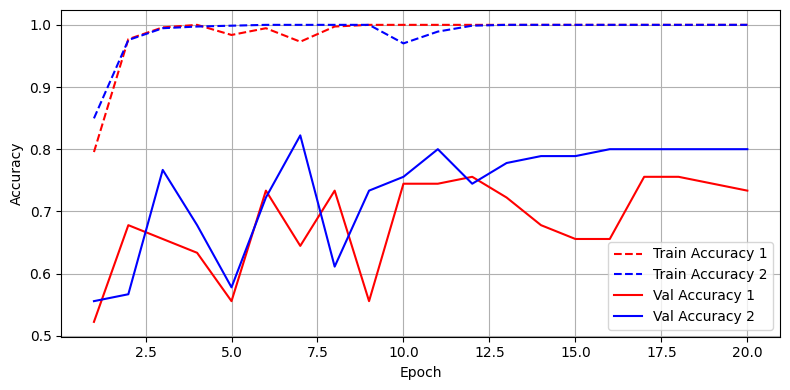

In [29]:
epochs = range(1, len(train_losses1) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses1, 'r-', label='Train Loss 1')
plt.plot(epochs, train_losses2, 'b-', label='Train Loss 2')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_accuracies1, 'r--', label='Train Accuracy 1')
plt.plot(epochs, train_accuracies2, 'b--', label='Train Accuracy 2')
plt.plot(epochs, val_accuracies1, 'r-', label='Val Accuracy 1')
plt.plot(epochs, val_accuracies2, 'b-', label='Val Accuracy 2')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
